In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week18_lipschitz_son'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set,
            {'COMPLETED': {'amazon_photo', 'citeseer', 'cora_full'},
             'FAILED': {'cora_full'}})

In [7]:
failed_exps = [r for r in collection.find() if r['status'] == 'FAILED']

In [8]:
print(''.join(failed_exps[0]['fail_trace']))

Traceback (most recent call last):
  File "/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/sacred/config/captured_function.py", line 42, in captured_function
    result = wrapped(*args, **kwargs)
  File "/tmp/079df0ee-a935-4a6c-8a21-373292b99f4a/training_semi_supervised_node_classification.py", line 171, in train
    return experiment.train()
  File "/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/sacred/config/captured_function.py", line 42, in captured_function
    result = wrapped(*args, **kwargs)
  File "/tmp/079df0ee-a935-4a6c-8a21-373292b99f4a/training_semi_supervised_node_classification.py", line 111, in train
    model = train_model(model, config, artifact_dir, data_loaders, logger=logger).eval()
  File "/tmp/079df0ee-a935-4a6c-8a21-373292b99f4a/train.py", line 224, in train_model
    return train_pl_model(model, config, artifact_dir, data_loaders, logger=logger)
  File "/tmp/079df0ee-a935-4a6c-8a21-373292b99f4a/train.py", line 108, in train_pl_model

In [9]:
collection_name = 'week18_lipschitz_son'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [10]:
list(experiments[0]['metrics'].keys())

['accuracy_val_val',
 'accuracy_id_val_val',
 'accuracy_ood_val_val',
 'accuracy_val_no-edges_val',
 'accuracy_id_val_no-edges_val',
 'accuracy_ood_val_no-edges_val',
 'ece_val_val',
 'ece_val_no-edges_val',
 'empirical_lipschitz_val_slope_mean_perturbation_noise_val',
 'empirical_lipschitz_val_slope_median_perturbation_noise_val',
 'empirical_lipschitz_val_slope_max_perturbation_noise_val',
 'empirical_lipschitz_val_slope_min_perturbation_noise_val',
 'empirical_lipschitz_val_slope_mean_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_median_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_max_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_min_perturbation_no-edges_val',
 'accuracy_ood-val_loc-no-edges_val',
 'accuracy_id_ood-val_loc-no-edges_val',
 'accuracy_ood_ood-val_loc-no-edges_val',
 'ood_auroc_total-predictive-entropy_loc-no-edges_val',
 'ood_aucpr_total-predictive-entropy_loc-no-edges_val',
 'misclassification_auroc_total-predictive-entropy_

In [11]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'


RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
SPECTRAL_OUTPUT_NORM = 'Spectral Norm on Last Layer'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower Lipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper Lipschitz Bound'



EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'

In [12]:
mode = 'val'

In [13]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'residual': True,
 'use_bias': True,
 'use_spectral_norm': True,
 'use_spectral_norm_on_last_layer': True,
 'weight_scale': 5.0}

In [14]:
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUROC'

In [15]:
Counter(ex['config']['model']['use_spectral_norm_on_last_layer'] for ex in experiments)

Counter({False: 2375, True: 2157})

In [16]:
data_proxy, data_acc_ece = [], []


for ex in experiments:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        RESIDUAL : cfg['model']['residual'],
        SPECTRAL_NORM : cfg['model']['use_spectral_norm'],
        WEIGHT_SCALE : cfg['model']['weight_scale'],
        SPECTRAL_OUTPUT_NORM : cfg['model']['use_spectral_norm_on_last_layer'],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    if not base[SPECTRAL_NORM]:
        base[WEIGHT_SCALE] = np.nan
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
                }
                )
                

In [17]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [18]:
df_proxy

,AUROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,Dataset,Empirical Lower Lipschitz Bound,Empirical Upper Lipschitz Bound,Accuracy,Expected Calibration Error
0,0.919820,True,Leave Out Classes,Aleatoric,Transductive,False,False,NaN,False,cora_full,0.004784,0.764188,0.814286,0.156444
1,0.975601,False,Leave Out Classes,Aleatoric,Transductive,False,False,NaN,False,cora_full,0.004784,0.764188,0.814286,0.156444
2,0.897549,False,Leave Out Classes,Epistemic,Transductive,False,False,NaN,False,cora_full,0.004784,0.764188,0.814286,0.156444
3,0.921930,True,Leave Out Classes,Aleatoric,Transductive,False,False,NaN,False,cora_full,0.005137,0.728910,0.785714,0.096689
4,0.985227,False,Leave Out Classes,Aleatoric,Transductive,False,False,NaN,False,cora_full,0.005137,0.728910,0.785714,0.096689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20383,0.507044,False,Bernoulli,Aleatoric,Inductive,True,True,5.0,True,amazon_photo,0.683646,7.061350,0.918750,0.149935
20384,0.655763,False,Bernoulli,Epistemic,Inductive,True,True,5.0,True,amazon_photo,0.683646,7.061350,0.918750,0.149935
20385,0.087241,True,Normal,Aleatoric,Inductive,True,True,5.0,True,amazon_photo,0.683646,7.061350,0.918750,0.149935
20386,0.398475,False,Normal,Aleatoric,Inductive,True,True,5.0,True,amazon_photo,0.683646,7.061350,0.918750,0.149935


In [19]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True, binned=True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            if binned:
                if x_style.shape[0] == 0:
                    continue
                else:
                    pass
                    # print(x_style.shape)
                mean, bin_edges, bin_idx = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], statistic='mean', bins=10)
                std, _, _ = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], bins=bin_edges, statistic='std')
                bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
                
            else:
                bin_centers = np.sort(np.unique(x_style))
                mean = np.array([(y_style[x_style == center]).mean() for center in bin_centers])
                std = np.array([(y_style[x_style == center]).std() for center in bin_centers])
            if log_x:
                bin_centers = np.exp(bin_centers)
                
               
            plot_mask = np.isfinite(mean) & np.isfinite(std)
            # print(plot_mask)

            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
             
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25), frameon=False)
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 0.99), frameon=False)
    
    if np.isfinite(df[df[SPECTRAL_NORM] == False][x]).any():
        lines, line_labels = [], []
        for style, marker in style_to_marker.items():
            lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
            line_labels.append(style)
        l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', frameon=False, bbox_to_anchor=(1.1, 0.7))
    else:
        l3 = l2
    
    g.axes.flatten()[-1].add_artist(l1)
    if l3 != l2:
        g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        pass
        g.set(xscale='log')
    return g

In [20]:
dataset = dc.AMAZON_PHOTO
setting = HYBRID

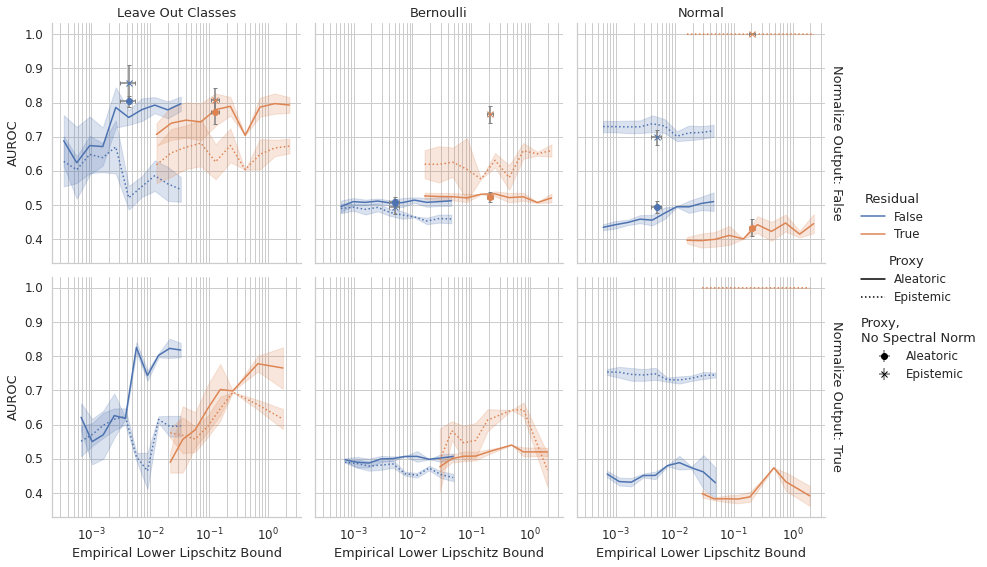

In [21]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == setting)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output: {row_name}', col_template = '{col_name}')

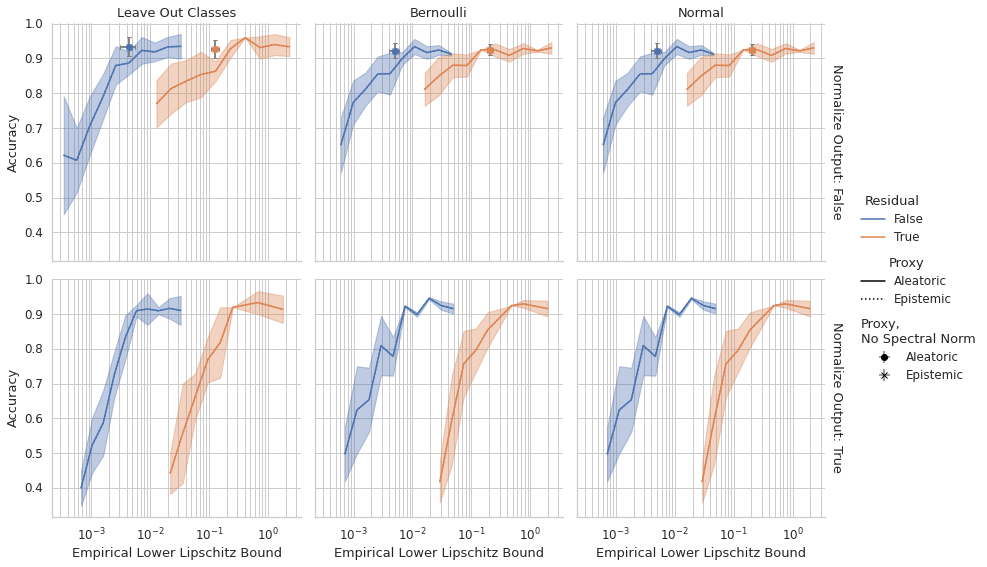

In [22]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == setting)
    ],
    x = LOWER_LIPSCHITZ, y = ACCURACY, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output: {row_name}', col_template = '{col_name}')

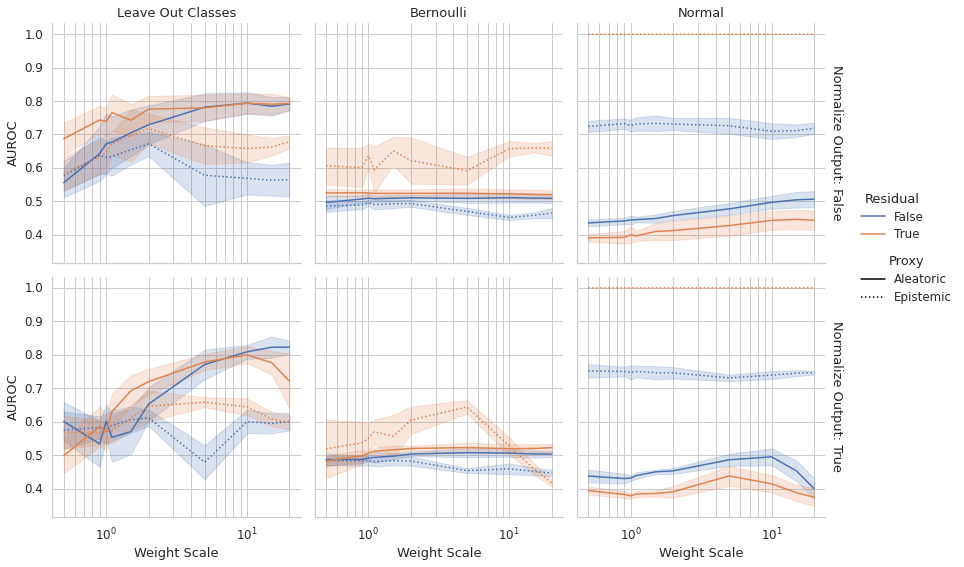

In [23]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == setting)
    ],
    x = WEIGHT_SCALE, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY, binned=False, log_x=True)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output: {row_name}', col_template = '{col_name}')

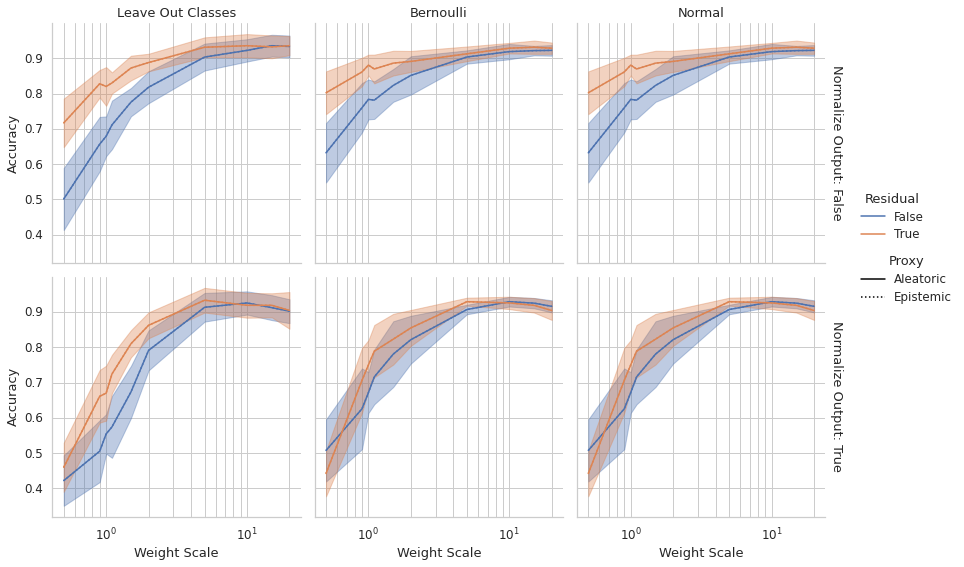

In [24]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dataset) &
        (df_proxy[SETTING] == setting)
    ],
    x = WEIGHT_SCALE, y = ACCURACY, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY, binned=False)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = 'Normalize Output: {row_name}', col_template = '{col_name}')

In [25]:
df_proxy[
    (df_proxy[DATASET] == dc.CITESEER) &
    (df_proxy[WEIGHT_SCALE] == 20.0)
    & (df_proxy[SETTING] == 'Inductive')
    & (df_proxy[EXPERIMENT] == BERNOULLI)
    & (df_proxy[RESIDUAL] == True)
    & (df_proxy[NO_EDGES] == False)
    & (df_proxy[PROXY] == EPISTEMIC)
]

,AUROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,Dataset,Empirical Lower Lipschitz Bound,Empirical Upper Lipschitz Bound,Accuracy,Expected Calibration Error
11576,0.999897,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,1.623794,16.455559,0.650000,0.167530
11582,0.998920,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,1.717012,15.888150,0.583333,0.076548
11588,0.987758,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,1.001696,11.984586,0.658333,0.088469
11594,0.999897,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,1.575024,15.805338,0.658333,0.166167
11600,0.998663,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,2.404701,22.537740,0.583333,0.086108
11606,0.962061,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,0.798181,11.187154,0.675000,0.126480
11612,0.954152,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,0.914453,9.499518,0.616667,0.124518
11618,0.997107,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,1.740210,16.453099,0.600000,0.128392
11624,0.965225,False,Bernoulli,Epistemic,Inductive,True,True,20.0,False,citeseer,0.875337,10.751164,0.666667,0.114030
11792,0.514769,False,Bernoulli,Epistemic,Inductive,True,True,20.0,True,citeseer,1.121767,10.835048,0.550000,0.314786
